In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import sys
import argparse
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

In [2]:
# Give a folder path as an argument with '--log_dir' to save
# TensorBoard summaries. Default is a log folder in current directory.
current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()

# Create the directory for TensorBoard variables if there is not.
if not os.path.exists(FLAGS.log_dir):
    os.makedirs(FLAGS.log_dir)

In [18]:
# Step 1: Fetch the data

# Fetch data
ng_all = fetch_20newsgroups(subset='all')

# Training and testing data
ng_data = ng_all.data

vocabulary = []
for i in range(len(ng_data)):
    for word in ng_data[i].replace('\n', ' ').replace('\t', ' ').replace('  ', ' ').split(' '):
        vocabulary.append(word) if word != '' else 0

print('Data size', len(vocabulary))

Data size 5345909


In [4]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000


def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 567756], ('the', 210207), ('to', 115712), ('of', 110386), ('a', 92634)]
Sample data [26, 0, 47922, 46, 24684, 25, 6556, 341, 6, 35012] ['From:', 'UNK', "(where's", 'my', 'thing)', 'Subject:', 'WHAT', 'car', 'is', 'this!?']


In [5]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

0 UNK -> 47922 (where's
0 UNK -> 26 From:
47922 (where's -> 0 UNK
47922 (where's -> 46 my
46 my -> 24684 thing)
46 my -> 47922 (where's
24684 thing) -> 25 Subject:
24684 thing) -> 46 my


In [6]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 300  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 100  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

    # Input data.
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                  tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                  tf.truncated_normal(
                  [vocabulary_size, embedding_size],
                  stddev=1.0 / math.sqrt(embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))

    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                    skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
        # Feed metadata variable to session for visualizing the graph in TensorBoard.
        _, summary, loss_val = session.run(
            [optimizer, merged, loss],
            feed_dict=feed_dict,
            run_metadata=run_metadata)
        average_loss += loss_val

        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

    # Write corresponding labels for the embeddings.
    with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
        for i in xrange(vocabulary_size):
            f.write(reverse_dictionary[i] + '\n')

    # Save the model for checkpoints.
    saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

    # Create a configuration for visualizing embeddings with the labels in TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

writer.close()

Initialized
Average loss at step  0 :  307.65606689453125
Nearest to my: damage,, tcora@pica.army.mil, driver., format), Barlow, twist, spending., 386/25,
Nearest to From:: disappointed., He'll, (Tom), degrees, POM, EDO, ), autoexec.bat.,
Nearest to are: essence, Flyer, Parker, invokes, was,, sometime., defect, accumulate,
Nearest to been: localhost, rebuild, deficiency, villages?, NAMBLA, calmly, please!, How,
Nearest to out: FAQs, hadith, digging, Writer, repeated, Infants, pump., A:.,
Nearest to Subject:: $225, MacInteresteds, Berube, sites., reverted, myself.", culture, Selannes,
Nearest to should: insulated, pdb059@ipl.jpl.nasa.gov, Larkin, 534, him)., Independence", past, logic,
Nearest to one: *great*, Dick, "No, *need*, Kitchen, neighbour, sky?, one-third,
Nearest to was: Fahrenheit), speakers,, >time., Everett, benefits:, workers., Zhasmen, PC's,,
Nearest to were: candida., cdp.UUCP!cpr, membership, <wdstarr@athena.mit.edu>, Exp, complex, attempts., mute,
Nearest to but: sins,

Average loss at step  2000 :  127.08405418205261
Average loss at step  4000 :  56.86386609649658
Average loss at step  6000 :  35.78159421348572
Average loss at step  8000 :  139.1876124896407
Average loss at step  10000 :  33.48516227483749
Nearest to my: the, a, UNK, and, not, I'm, to, was,
Nearest to From:: install., Brick, optarg;, /--, yap, Joliet, division?, ************************************************************,
Nearest to are: is, UNK, do, in, the, a, would, I'm,
Nearest to been: UNK, as, localhost, with, #>, of, villages?, no,
Nearest to out: AVI, yap, assembler, with, SSRT, Joliet, colony, Robinson,,
Nearest to Subject:: observations., K(>, kmagnacca@eagle.wesleyan.edu, FPU., spikes, Ethernet., yap, floptical,
Nearest to should: Larkin, of, K(>, /--, the, yap, type., Roehm,
Nearest to one: the, UNK, that, a, not, do, and, I'm,
Nearest to was: is, in, UNK, and, are, to, that, be,
Nearest to were: are, do, is, and, UNK, a, was, the,
Nearest to but: is, and, do, in, UNK, w

Nearest to your: the, a, will, my, and, their, think, to,
Nearest to that: in, it, and, if, from, of, on, with,
Nearest to only: >, a, as, necessarily, to, used, that, just,
Nearest to at: of, in, from, and, with, for, to, UNK,
Nearest to me: even, it, as, to, >, the, and, or,
Nearest to in: on, for, of, with, that, from, In, own,
Nearest to by: in, and, from, to, for, was, that, is,
Nearest to not: /--, yap, K(>, <o&o, karl, optarg;, >>#, Joliet,
Nearest to or: and, >, to, were, as, a, be, was,
Nearest to could: will, would, to, and, should, >, a, the,
Nearest to who: that, >, to, which, it, I, what, this,
Nearest to I: you, they, we, it, K(>, /--, to, rickert@NeXTwork.Rose-Hulman.Edu,
Nearest to with: in, on, for, of, that, from, In, at,
Nearest to I'm: >, is, does, be, am, a, was, do,
Nearest to the: a, my, >, this, to, some, any, will,
Nearest to get: of, in, got, UNK, for, and, with, that,
Nearest to than: from, if, as, and, got, way, that, >,
Nearest to also: to, >, not, could, j

Nearest to an: a, the, your, sure, their, using, structures,, UNK,
Nearest to which: that, and, got, really, in, who, saying, UNK,
Nearest to if: when, as, that, what, but, If, and, -,
Nearest to will: would, can, must, is, may, could, to, and,
Nearest to it: this, I, you, he, UNK, that, [FORGED], we,
Nearest to of: for, on, from, with, at, in, <o&o, that,
Nearest to what: that, if, UNK, did, hope, and, not, sure,
Nearest to This: It, I, >, The, Plays, There, Quicken, Bobby.,
Nearest to up: to, read, like, That's, that, necessarily, checking, in,
Nearest to from: on, for, UNK, in, to, of, that, IK>,
Nearest to can: will, would, to, might, and, have, should, is,
Nearest to his: the, your, a, and, our, it's, TRUE, run,
Nearest to --: >, -, by, |, if, and, when, gargle,
Nearest to like: have, that, know, in, find, >, with, see,
Nearest to any: a, the, some, no, or, DB, much, and,
Nearest to for: on, in, with, to, UNK, from, of, <o&o,
Nearest to when: if, that, as, If, and, next, in, but,


Average loss at step  50000 :  8.829677775621414
Nearest to my: your, the, their, a, this, his, our, you,
Nearest to From:: |, install., FULLY, article, |>HE], --, hero, optarg;,
Nearest to are: were, is, have, be, UNK, was, X#include, (Keown,
Nearest to been: be, was, were, am, by, <o&o, have, are,
Nearest to out: UNK, the, to, home, is, know, with, off,
Nearest to Subject:: writes:, kmagnacca@eagle.wesleyan.edu, Effect, K(>, you,", <o&o, Re:, Hsieh),
Nearest to should: would, will, can, could, may, must, don't, to,
Nearest to one: a, UNK, is, or, the, that, it, some,
Nearest to was: is, be, has, were, am, have, are, and,
Nearest to were: are, was, be, have, is, and, ><>, do,
Nearest to but: and, or, so, as, -, was, because, that,
Nearest to :: >, 20:00, Opus, K(>, P,#, Drives, is),, Sharks,,
Nearest to Re:: 300i, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', KB, (Sun, Subject:, >Gary, Giants', (Compulsive,
Nearest to |: gargle, K(>, /--, [FORGED], yap, juice, floptic

Nearest to had: have, has, was, is, be, and, were, (Keown,
Nearest to >: |>, >>, UNK, :, gargle, Mp/s, (Keown, P,#,
Nearest to your: my, the, their, his, a, this, our, Joliet,
Nearest to that: and, which, in, to, have, as, on, of,
Nearest to only: that, UNK, necessarily, most, just, to, (Wim, as,
Nearest to at: in, for, of, on, to, from, and, with,
Nearest to me: him, them, you, it, even, us, hardcopy, IK>,
Nearest to in: on, with, for, from, by, of, and, to,
Nearest to by: in, for, was, be, with, to, as, of,
Nearest to not: to, be, it, that, UNK, also, Mp/s, you,
Nearest to or: and, but, in, -, that, for, <o&o, one,
Nearest to could: can, would, will, should, to, can't, cannot, "Elohim,",
Nearest to who: that, you, I, he, they, which, to, we,
Nearest to I: you, they, we, he, it, They, We, You,
Nearest to with: in, on, for, to, and, of, have, by,
Nearest to I'm: I, am, is, >, are, was, be, you're,
Nearest to the: this, your, my, their, a, his, it, The,
Nearest to get: have, be, got, fi

Nearest to be: have, was, been, were, are, is, get, by,
Nearest to don't: would, can, should, will, do, not, didn't, are,
Nearest to The: the, A, If, (Keown, This, In, tw, O_RDONLY,,
Nearest to all: -$10, UNK, that, Mp/s, ______________________________________________, those, P,#, self-respecting,
Nearest to an: the, your, donot, structures,, type., my, unbelievers, kt>,
Nearest to which: that, and, who, but, what, -$10, or, <o&o,
Nearest to if: when, what, that, as, (Keown, for, rickert@NeXTwork.Rose-Hulman.Edu, yap,
Nearest to will: would, can, should, could, may, must, to, don't,
Nearest to it: he, this, I, there, they, you, we, It,
Nearest to of: for, in, to, from, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', <o&o, and, with,
Nearest to what: that, if, how, why, where, (Keown, -$10, UNK,
Nearest to This: It, There, The, this, He, P,#, I, Mp/s,
Nearest to up: back, me, -$10, clamp, realy, them, jim@jagubox.gsfc.nasa.gov, wrong,,
Nearest to from: in, on, to, with, o

Average loss at step  82000 :  4.584618181645871
Average loss at step  84000 :  12.603182230949402
Average loss at step  86000 :  16.96245716776894
Average loss at step  88000 :  5.089785951375961
Average loss at step  90000 :  4.680389018177986
Nearest to my: your, their, his, the, our, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', #, this,
Nearest to From:: |, article, --, If, -$10, FULLY, #, He'll,
Nearest to are: were, is, was, do, be, don't, have, would,
Nearest to been: be, was, were, am, by, #, had, have,
Nearest to out: #, ppd, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', -$10, AVI, off, Joliet, >|>>},
Nearest to Subject:: writes:, Re:, #, says:, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', Effect, -$10, <o&o,
Nearest to should: would, will, can, could, don't, may, must, did,
Nearest to one: MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', #, discs, cryptosystem,, -$10, a, it, Xvoid,
Nearest to was: is, has, be,

Nearest to The: the, A, This, If, #, (Keown, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', It,
Nearest to all: #, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', -$10, Mp/s, that, keymap(None)\n\, UNK, self-respecting,
Nearest to an: #, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', the, your, donot, Manes, structures,, ________________________________________,
Nearest to which: that, and, who, but, what, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', #, This,
Nearest to if: when, what, #, If, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', for, as, that,
Nearest to will: would, can, should, could, may, must, to, don't,
Nearest to it: #, he, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', /--, yap, this, [FORGED], Joliet,
Nearest to of: for, in, #, about, a, on, from, 24,
Nearest to what: that, how, if, #, MAX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>'AX>', why, (Keown, -$10,
Neares

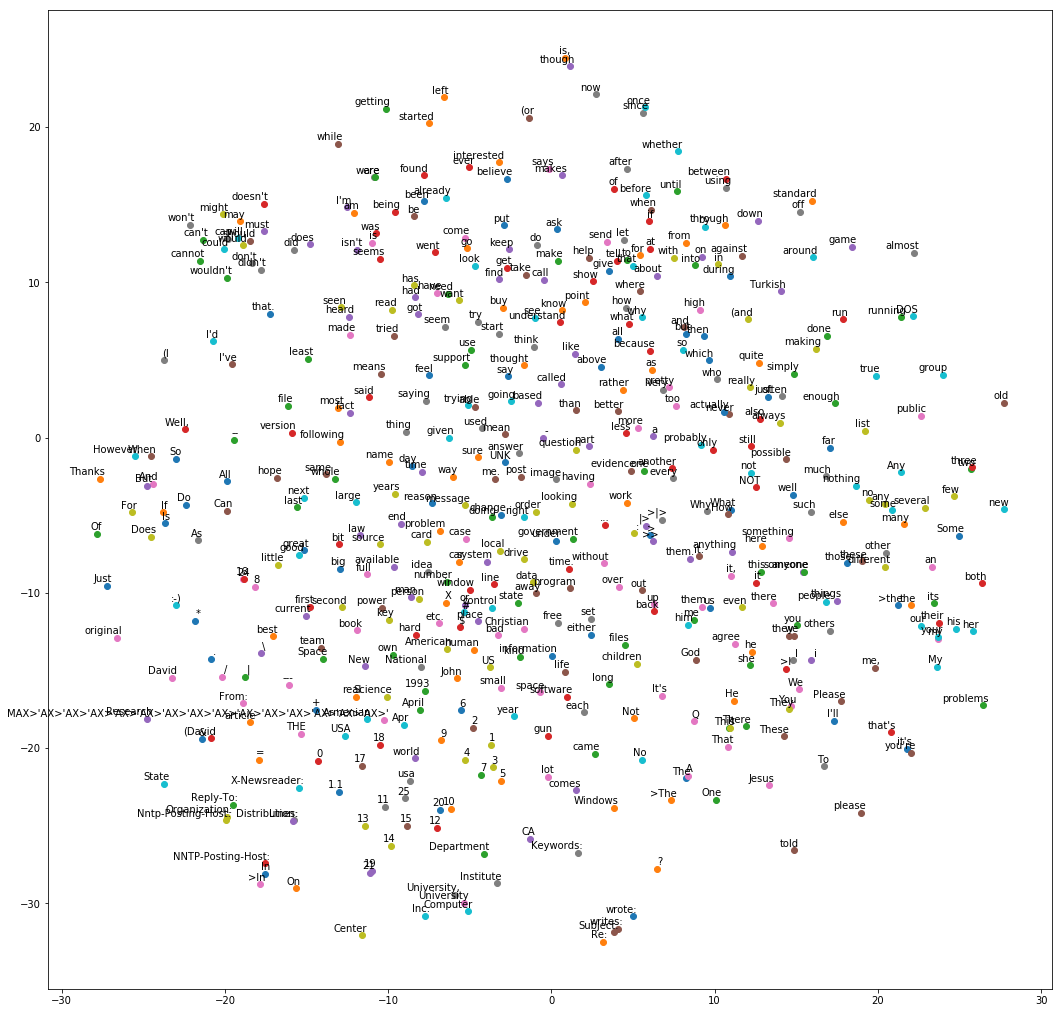

In [13]:
# Step 6: Visualize the embeddings.

# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(
        perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)

In [9]:
def k_most_similar_words(word, k):
    final_embeddings_distance_matrix = euclidean_distances([final_embeddings[dictionary[word]]], final_embeddings)

    final_embeddings_distance_matrix = np.argsort(final_embeddings_distance_matrix[0])[:21]
    final_embeddings_distance_matrix = np.delete(final_embeddings_distance_matrix, 0)

    for index in final_embeddings_distance_matrix:
        print(reverse_dictionary[index])

In [17]:
k_most_similar_words('one', 20)

or
a
Xvoid
/--
UNK
yap
Paperback.
#
didnt
Joliet
K(>
CAL,
discs
Mp/s
Opus
>>#
<o&o
to
Gilkey
karl
